In [50]:
# create 3 pandas datasets with the data of selected compounds and the corresponding average movement speed of the animal
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [51]:
# options
log_transform = True

In [52]:
# raw data files list
files_list = ['List_of_detected_peak_pairs_vivoDay1_0619.csv', '10_InVivo_Dansyl.csv', '11_InVivo_Dansyl.csv']
# read data
dfs = [pd.read_csv(f) for f in files_list]

In [53]:
Tier3 = dfs[2]['Compound'].isna() * dfs[2]['Compound.1'].isna()
# merge dfs[2] compound names
dfs[2]['Compound'] = dfs[2]['Compound'].fillna(dfs[2]['Compound.1'])
# merge RT Error
dfs[2]['RT Error (s)'] = dfs[2]['RT Error (s)'].fillna(dfs[2]['RT Error (s).1'])
# merge NovaMT Library No.
dfs[2]['NovaMT Library No.'] = dfs[2]['NovaMT Library No.'].fillna(dfs[2]['NovaMT Library No..1'])
# rename Unnamed: 9 to Identification Level
dfs[2] = dfs[2].rename(columns={'Unnamed: 9': 'Identification Level'})

In [54]:
# Filter for Tier 1&2 compounds
tier_dfs = [df[(df["Identification Level"] == "Tier 1") + (df["Identification Level"] == "Tier 2")] for df in dfs]
# tier_dfs.append(dfs[2][Tier3 == False])
# extract compounds names
compounds = [df["Compound"].tolist() for df in tier_dfs]

In [55]:
[len(c) for c in compounds]

[241, 343, 345]

In [56]:
# take intersection of compounds in all 3 datasets
common_comps = list(set(compounds[0]).intersection(set(compounds[1])).intersection(set(compounds[2])))
# # sort common compounds
common_comps.sort()

# find the group of total compounds -- union
union_comps = list(set(compounds[0]).union(set(compounds[1])).union(set(compounds[2])))

In [57]:
len(union_comps)

482

In [58]:
# order datasets according to union comp
data_order = []
for i in range(3):
    data_order.append(dfs[i][dfs[i]['Compound'].isin(union_comps)].copy())
    data_order[i] = data_order[i].set_index('Compound').reindex(union_comps).reset_index()
    # if not in Tier 1 or Tier 2, set to NaN
    data_order[i].loc[~data_order[i]['Compound'].isin(compounds[i]), data_order[i].columns != 'Compound'] = np.nan
# order so as to have common compounds first
data_order = [pd.concat([td[td["Compound"].isin(common_comps)], td[~td["Compound"].isin(common_comps)]]) for td in data_order]

In [59]:
# data_order_order extraction and columns renaming (specific for data_orderset of day 1)
metadata_order = [d.iloc[:,:21] for d in data_order]
data_order[0] = data_order[0].iloc[:,21:-4]
if log_transform:
    data_order[0] = data_order[0].transform(lambda x: np.log2(x))
new_columns = []
for col in data_order[0].columns:
    name = col[-6:]
    if name[0] == '_':
        name = name[1:]
    new_columns.append(name)
data_order[0].columns = new_columns

# columns renaming (specific for data_orderset of day 2)
data_order[1] = data_order[1].iloc[:,21:-3]
if log_transform:
    data_order[1] = data_order[1].transform(lambda x: np.log2(x))
new_columns = []
for col in data_order[1].columns:
    parts = col.split('.')
    if len(parts) >= 2:
        new_col = f"{parts[0]}{int(float(parts[1])/2)+1}_{0}{int(float(parts[1])%2+1)}"
    else:
        new_col = col+"1_01"  # Default to _01 if no replicate info
    new_columns.append(new_col)
data_order[1].columns = new_columns

# columns renaming (specific for data_orderset of day 3)
data_order[2] = data_order[2].iloc[:, 24:-3]
if log_transform:
    data_order[2] = data_order[2].transform(lambda x: np.log2(x))
new_columns = []
for icol in np.arange(0,data_order[2].shape[1],2):
    new_columns.append(f"{int(icol/2)+1}_01")
    new_columns.append(f"{int(icol/2)+1}_02")
data_order[2].columns = new_columns

In [60]:
# remove dirty technical replicates and robust-zscore
def rob_zscore(x):
    median = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - median))
    if mad == 0:
        return np.zeros_like(x)
    return (x - median) / mad

def clean_row(row, thr=1):
    # 1) compute abs difference of each consecutive pair
    row_clean = []
    for i in range(1, len(row), 2):
        diff = np.abs(row[i] - row[i-1])
        if diff > thr:
            row_clean.append(np.nan)
        else:
            row_clean.append(np.mean(row[i-1:i+1]))
    return np.array(row_clean)

# do the cleaning
clean_data = []
for id, d in enumerate(data_order):
    clean_data.append([])
    for i in range(d.shape[0]):
        clean_data[id].append(clean_row(d.iloc[i,:].values, thr=1))
    clean_data[id] = np.array(clean_data[id])

In [61]:
len(common_comps), len(union_comps)

(155, 482)

In [62]:
# for day 1 and day 2, split into morning and afternoon
# day 1 
day1_morning = clean_data[0][:, :26]
day1_afternoon = clean_data[0][:, 26:]
# day 2
day2_morning = clean_data[1][:, :32]
day2_afternoon = clean_data[1][:, 32:]
# day3
day3 = clean_data[2]
# print shapes
day1_morning.shape, day1_afternoon.shape, day2_morning.shape, day2_afternoon.shape, day3.shape

((482, 26), (482, 29), (482, 32), (482, 33), (482, 64))

In [63]:
# put together day1_morening and day1_afternoon and be aware of the gap in between
filename = 'mn_20250619_093749DLC_clean.csv'
day1_beh_morning = pd.read_csv(filename)
day1_beh_morning['time'] = pd.to_datetime(day1_beh_morning['time'])
filename = 'mn_20250619_141151DLC_clean.csv'
day1_beh_afternoon = pd.read_csv(filename)
day1_beh_afternoon['time'] = pd.to_datetime(day1_beh_afternoon['time']) + pd.Timedelta(hours=12)  # add 12 hours to the afternoon time

filename = 'mn_20250620_142949DLC_clean.csv'
day2_beh_afternoon = pd.read_csv(filename)
day2_beh_afternoon['time'] = pd.to_datetime(day2_beh_afternoon['time']) + pd.Timedelta(hours=12)  # add 12 hours to the afternoon time
filename = 'mn_20250620_091517DLC_clean.csv'
day2_beh_morning = pd.read_csv(filename)
day2_beh_morning['time'] = pd.to_datetime(day2_beh_morning['time'])

# day 3
filename = 'mn_20250825_093313DLC_clean.csv'
day3_beh = pd.read_csv(filename)
day3_beh['time'] = pd.to_datetime(day3_beh['time'])

In [64]:
day1_beh_morning['time'] = day1_beh_morning['time'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day1_beh_morning['time_bin'] = ((day1_beh_morning['time'] - day1_beh_morning['time'][0]) // 450)
# calculate the mean speed for each bin
day1_beh_morning['mean_speed'] = day1_beh_morning.groupby('time_bin')['neck_speed'].transform('mean')

In [65]:
filename = 'mn_20250619_141151DLC_clean.csv'
day1_beh_afternoon = pd.read_csv(filename)
day1_beh_afternoon['time'] = pd.to_datetime(day1_beh_afternoon['time'])
day1_beh_afternoon = day1_beh_afternoon[day1_beh_afternoon['time'] <= '2025-06-19 05:44:00']
## there is a two minutes gap due to a power loss at time 4:06. Remove 4:06 to 4:08
day1_beh_postpowerloss = day1_beh_afternoon[day1_beh_afternoon['time'] >= '2025-06-19 04:08:00']
day1_beh_postpowerloss.loc[:,'time'] = day1_beh_postpowerloss['time'] - pd.Timedelta(minutes=2)
# remove two minutes gap
day1_beh_afternoon = pd.concat([day1_beh_afternoon[day1_beh_afternoon['time'] < '2025-06-19 04:06:00'],
                                 day1_beh_postpowerloss])
# turn everything into seconds
day1_beh_afternoon['time'] = day1_beh_afternoon['time'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day1_beh_afternoon['time_bin'] = ((day1_beh_afternoon['time'] - day1_beh_afternoon['time'][0]) // 450)
# calculate the mean speed for each bin
day1_beh_afternoon['mean_speed'] = day1_beh_afternoon.groupby('time_bin')['neck_speed'].transform('mean')

In [66]:
filename = 'mn_20250620_142949DLC_clean.csv'
day2_beh_afternoon = pd.read_csv(filename)
day2_beh_afternoon['time'] = pd.to_datetime(day2_beh_afternoon['time'])
day2_beh_afternoon['time'] = day2_beh_afternoon['time'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day2_beh_afternoon['time_bin'] = ((day2_beh_afternoon['time'] - day2_beh_afternoon['time'][0]) // 450)
# calculate the mean speed for each bin
day2_beh_afternoon['mean_speed'] = day2_beh_afternoon.groupby('time_bin')['neck_speed'].transform('mean')

In [67]:
filename = 'mn_20250620_091517DLC_clean.csv'
day2_beh_morning = pd.read_csv(filename)
day2_beh_morning['time'] = pd.to_datetime(day2_beh_morning['time'])
day2_beh_morning['time'] = day2_beh_morning['time'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day2_beh_morning['time_bin'] = ((day2_beh_morning['time'] - day2_beh_morning['time'][0]) // 450)
# calculate the mean speed for each bin
day2_beh_morning['mean_speed'] = day2_beh_morning.groupby('time_bin')['neck_speed'].transform('mean')

In [68]:
filename = 'mn_20250825_093313DLC_clean.csv'
day3_beh = pd.read_csv(filename)
day3_beh['time'] = pd.to_datetime(day3_beh['time'])
day3_beh = day3_beh[day3_beh['time'] <= '2025-08-25 17:33:00']
# # turn everything into seconds
day3_beh['time'] = day3_beh['time'].apply(lambda x: x.hour * 3600 + x.minute*60 + x.second)
# # start from the first time point, and bin the data into 7.5 minute bins (450 seconds)
day3_beh['time_bin'] = ((day3_beh['time'] - day3_beh['time'][0]) // 450)
# # calculate the mean speed for each bin
day3_beh['mean_speed'] = day3_beh.groupby('time_bin')['neck_speed'].transform('mean')

In [69]:
# select only the unique values of mean speed (in order)
day1_morning_meanspeed = day1_beh_morning['mean_speed'].unique()
day1_afternoon_meanspeed = day1_beh_afternoon['mean_speed'].unique()
day2_morning_meanspeed = day2_beh_morning['mean_speed'].unique()
day2_afternoon_meanspeed = day2_beh_afternoon['mean_speed'].unique()
day3_meanspeed = day3_beh['mean_speed'].unique()
# print lengths
len(day1_morning_meanspeed), len(day1_afternoon_meanspeed), len(day2_morning_meanspeed), len(day2_afternoon_meanspeed), len(day3_meanspeed)

(25, 28, 31, 32, 64)

In [70]:
day3.shape

(482, 64)

In [71]:
# we measured a delay of 15 minutes. So 2 bins delay for the hormones in order to be aligned!
X1m = day1_morning[:, 2:]  # remove first two samples to align with behavior
X1a = day1_afternoon[:, 2:]  # remove first two samples to align with behavior
X2m = day2_morning[:, 2:]  # remove first two samples to align with behavior
X2a = day2_afternoon[:, 2:]  # remove first two samples to align with behavior
X3 = day3[:,2:] # remove first 15 minutes
y1m = day1_morning_meanspeed[:-1]  # remove last two samples to align with hormones
y1a = day1_afternoon_meanspeed[:-1]  # remove last two samples to align with hormones
y2m = day2_morning_meanspeed[:-1]  # remove last two samples to align with hormones
y2a = day2_afternoon_meanspeed[:-1]  # remove last two samples to align with hormones
y3 = day3_meanspeed[:-2]  # remove last two samples to align with hormones


In [72]:
X1m.shape, X1a.shape, X2m.shape, X2a.shape, X3.shape

((482, 24), (482, 27), (482, 30), (482, 31), (482, 62))

In [73]:
y1m.shape, y1a.shape, y2m.shape, y2a.shape, y3.shape

((24,), (27,), (30,), (31,), (62,))

In [74]:

# fill nan with interpolation
from scipy.interpolate import interp1d
def fill_nan_with_interpolation(arr):
    nans = np.isnan(arr)
    if np.all(nans):
        return arr  # return as is if all values are NaN
    x = np.arange(len(arr))
    f = interp1d(x[~nans], arr[~nans], kind=1, bounds_error=False, fill_value="extrapolate")
    return f(x)
# fill nan for X and y
X1m = np.array([fill_nan_with_interpolation(row) for row in X1m])
X1a = np.array([fill_nan_with_interpolation(row) for row in X1a])
X2m = np.array([fill_nan_with_interpolation(row) for row in X2m])
X2a = np.array([fill_nan_with_interpolation(row) for row in X2a])
X3 = np.array([fill_nan_with_interpolation(row) for row in X3])

In [75]:
X1m.shape, X1a.shape, X2m.shape, X2a.shape, X3.shape, y1m.shape, y1a.shape, y2m.shape, y2a.shape, y3.shape

((482, 24),
 (482, 27),
 (482, 30),
 (482, 31),
 (482, 62),
 (24,),
 (27,),
 (30,),
 (31,),
 (62,))

In [76]:
# define robust z-score function
def rob_zscore(x,axis=0):
    median = np.nanmedian(x, axis=axis)
    mad = np.nanmedian(np.abs(x - median), axis=axis)
    return (x - median) / mad

In [77]:
# concatenate X1m, a np.zeros(9, 155), and X1a
X1_full = np.hstack((X1m, np.zeros((X1m.shape[0], 9))*np.nan, X1a))
X1_full = np.vstack([X1_full, np.zeros((X3.shape[0]-X1_full.shape[0], X1_full.shape[1]))*np.nan])
y1_full = np.hstack((y1m, np.zeros(9)*np.nan, y1a))

# concatenate X2m, a np.zeros   (9, 155), and X2a
X2_full = np.hstack((X2m, np.zeros((X2m.shape[0], 9))*np.nan, X2a))
X2_full = np.vstack([X2_full, np.zeros((X3.shape[0]-X2_full.shape[0], X2_full.shape[1]))*np.nan])
y2_full = np.hstack((y2m, np.zeros(9)*np.nan, y2a))

In [78]:
np.mean(np.isnan(X3[:,0]))

np.float64(0.2842323651452282)

/tmp/ipykernel_719022/1956488916.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


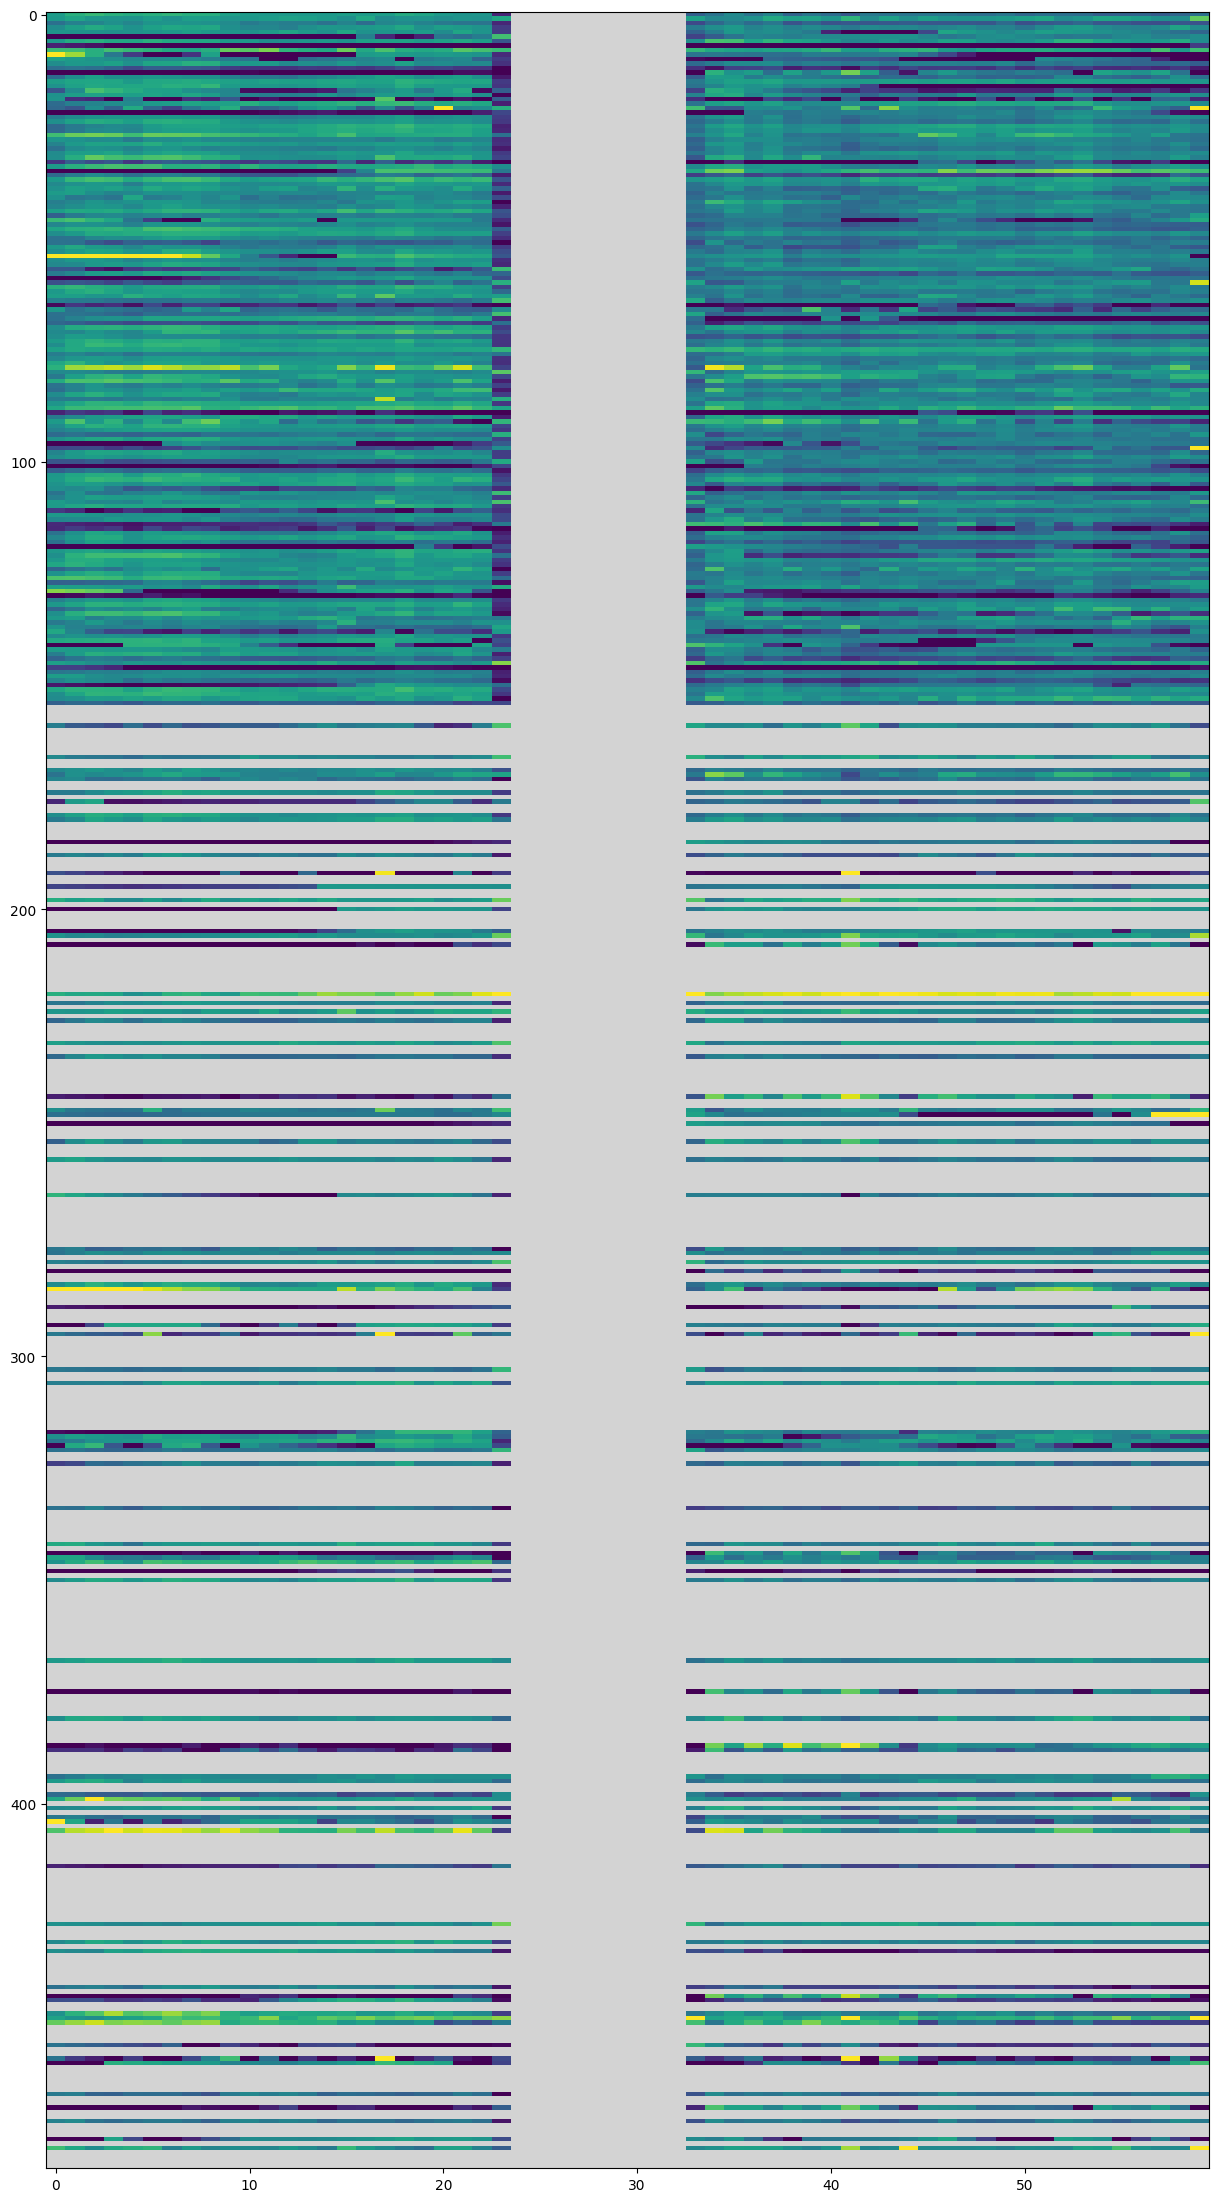

In [96]:
cmap = plt.cm.get_cmap('viridis')
cmap.set_bad('lightgray') # Set the color for NaNs to light gray
plt.figure(figsize=(15,28))
plt.imshow(X1_full, aspect='auto', cmap=cmap, vmin=-2.3, vmax=2.3)

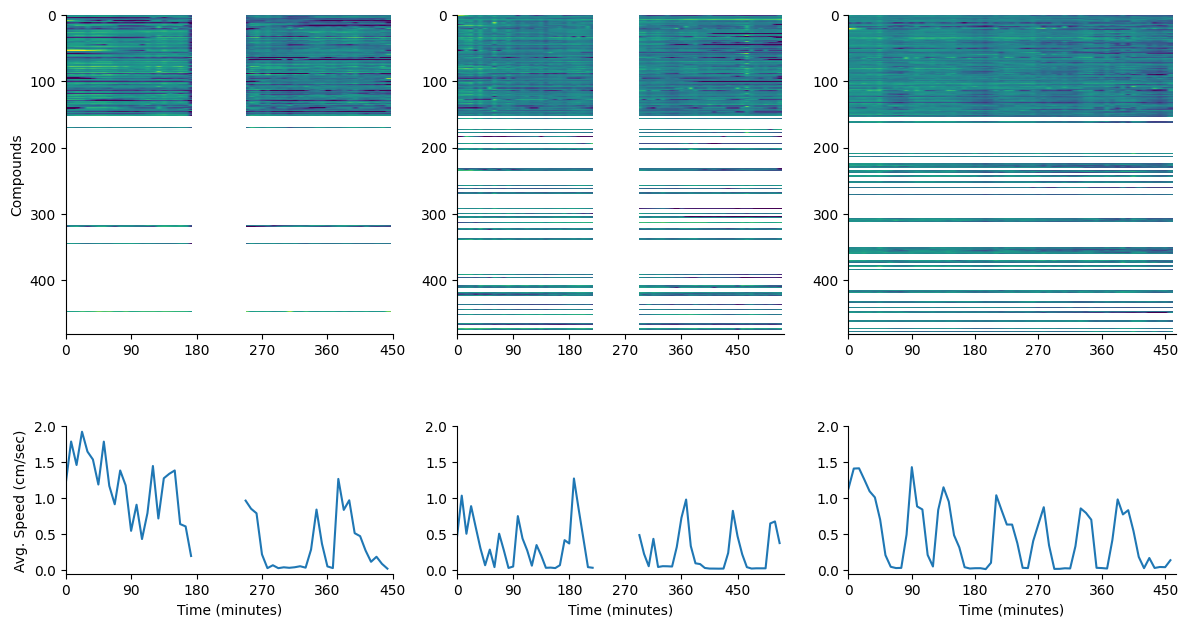

In [104]:
def anim_comps_speed(X, y, title='', pos=0):
    plt.subplot(2, 3, 1 + pos)
    plt.imshow(X, aspect='auto', cmap='viridis',vmin=-2.3, vmax=2.3, rasterized=True)
    plt.xticks([0,12,24,36,48,60],[0,90,180,270,360,450])
    if title[-1] == '1':
        plt.ylabel('Compounds')
    plt.xlim(0,len(y))
    # remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.subplot(4, 3, 7 + pos)
    plt.plot(y*2)
    plt.ylim(-0.05, 2)
    plt.xticks([0,12,24,36,48,60],[0,90,180,270,360,450])
    plt.xlabel('Time (minutes)')
    if title[-1] == '1':
        plt.ylabel('Avg. Speed (cm/sec)')
    plt.xlim(0,len(y))
    # remove spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
# plot imshow
plt.figure(figsize=(12, 8))
anim_comps_speed(X1_full, y1_full, title='Day 1', pos=0)
anim_comps_speed(X2_full, y2_full, title='Day 2', pos=1)
anim_comps_speed(X3, y3, title='Day 3', pos=2)
plt.tight_layout()
# plt.suptitle('Dansyl Ratios and Average Speed Over Time', y=
plt.savefig('heatmaps_union_lines_raw_aligned_full.pdf', dpi=900)